# DDA 4230 Tutorial 6

## Section 0:  Outline
1. Implement Grid World Environment
2. Implement & test Policy Iteration
3. Implement & test Value Iteration
4. Exercise


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from matplotlib.table import Table


## Section 1: Grid World 
<img src="https://i.loli.net/2021/03/23/ygEjuQSFobDdf1l.png" style="width: 800px;" center/>
<h3 style="text-align:right">From Example 4.1 in Reinforcement Learning: An Introduction </h3>

State Space: {1,2,3,...,14}

Action Space: {Left, Up, Right, Down}

Reward: -1 for all transitions

In [2]:
class GridWorld:
    '''
    A Gym-style GridWorld Environment
    '''

    def __init__(self, world_size=4):
        self.world_size = world_size
        # left, up, right, down
        self.actions = [np.array([0, -1]),
                        np.array([-1, 0]),
                        np.array([0, 1]),
                        np.array([1, 0])]
        self.nS = world_size*world_size
        self.nA = 4
        self.reset()
        self.P = self.create_P()

    def create_P(self):
        '''
        In general, we need construct P first and build 'step' based on P. 
        Here we build 'step' first for convenience.
        '''
        P = {state: {action: []
                     for action in range(self.nA)} for state in range(self.nS)}
        for state in range(self.nS):
            for action in range(self.nA):
                next_state, reward = self.act(state, action)
                done = self.is_terminal(next_state)
                info = dict()
                P[state][action].append((1.0, next_state, reward, done))
        return P

    def encode(self, cell_state):
        x, y = cell_state
        return x*self.world_size+y

    def decode(self, state):
        return [state//self.world_size, state % self.world_size]

    def reset(self):
        self.state = 1

    def is_terminal(self, state=None):
        if not (state is None):
            x, y = self.decode(state)
        else:
            x, y = self.decode(self.state)
        return (x == 0 and y == 0) or (x == self.world_size - 1 and y == self.world_size - 1)

    def act(self, state, action):
        cell_state = self.decode(state)
        action = self.actions[action]
        if self.is_terminal(state):
            return state, 0
        next_cell_state = (np.array(cell_state) + action).tolist()
        x, y = next_cell_state
        if x < 0 or x >= self.world_size or y < 0 or y >= self.world_size:
            next_cell_state = cell_state
        reward = -1
        return self.encode(next_cell_state), reward

    def step(self, action):
        next_state, reward = self.act(self.state, action)
        self.state = next_state
        return next_state, reward
    ############################################## Optional ##############################################
    def draw_policy(self, optimal_values):
        ACTIONS_FIGS = ['←', '↑', '→', '↓']
        fig, ax = plt.subplots()
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])

        nrows, ncols = optimal_values.shape
        width, height = 1.0 / ncols, 1.0 / nrows

        # Add cells
        for (i, j), val in np.ndenumerate(optimal_values):
            next_vals = []
            for action in range(env.nA):
                next_state, _ = self.act(i*4+j, action)
                next_state = self.decode(next_state)
                next_vals.append(optimal_values[next_state[0], next_state[1]])

            best_actions = np.where(next_vals == np.max(next_vals))[0]
            val = ''
            for ba in best_actions:
                val += ACTIONS_FIGS[ba]
            tb.add_cell(i, j, width, height, text=val,
                        loc='center', facecolor='white')

        # Row and column labels...
        for i in range(len(optimal_values)):
            tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                        edgecolor='none', facecolor='none')
            tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                        edgecolor='none', facecolor='none')

        ax.add_table(tb)

    def draw_image(self, image):
        fig, ax = plt.subplots()
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])

        nrows, ncols = image.shape
        width, height = 1.0 / ncols, 1.0 / nrows

        # Add cells
        for (i, j), val in np.ndenumerate(image):
            tb.add_cell(i, j, width, height, text=val,
                        loc='center', facecolor='white')

            # Row and column labels...
        for i in range(len(image)):
            tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                        edgecolor='none', facecolor='none')
            tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                        edgecolor='none', facecolor='none')
        ax.add_table(tb)


In [3]:
env=GridWorld()
env.reset()
for _ in range(5):
    print(env.step(2),end = '→')
print(env.step(2))

(2, -1)→(3, -1)→(3, -1)→(3, -1)→(3, -1)→(3, -1)


## Section 2: Policy Iteration

<img src="https://i.loli.net/2021/03/23/x4LwqiNTUh7ycKC.png" style="width: 800px;" center/>
<img src="https://i.loli.net/2021/03/23/ma6qHyOAUklshQv.png" style="width: 800px;" center/>


In [4]:
def policy_evaluation(policy, env, discount_factor=1.0, theta=1e-5):
    """
    Implement the policy evluation algorithm here given a policy and a complete model of the environment.
    
    
    Arguments:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: This is the minimum threshold for the error in two consecutive iteration of the value function.
        discount_factor: This is the discount factor - Gamma.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    V = np.zeros(env.nS)
    
    counter = 0
    
    while True:
        counter += 1
        delta = 0
        for s in range(env.nS):
            vNew = 0
            for a in range(env.nA):
                for prob, nextState, reward, done in env.P[s][a]:
                    vNew+=policy[s][a] * prob * (reward + discount_factor*V[nextState])
            
            delta = max(delta, np.abs(V[s]-vNew))
            V[s] = vNew
                
        if delta < theta:
            break

    return np.array(V)


In [5]:
def policy_iteration(env, policy_eval_fn=policy_evaluation, discount_factor=1.0):
    """
    Implement the Policy Improvement Algorithm here which iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Arguments:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    def one_step_lookahead(state, V):
        """
        Implement the function to calculate the value for all actions in a given state.
        
        Arguments:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, nextState, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[nextState])
        return A

    policy = np.ones([env.nS, env.nA]) / env.nA
    
    numIterations = 0

    while True:
        numIterations += 1
        
        V = policy_eval_fn(policy, env, discount_factor)
        policyStable = True
        for s in range(env.nS):
            oldAction = np.argmax(policy[s])
            qValues = one_step_lookahead(s, V)
            newAction = np.argmax(qValues)
            if oldAction != newAction:
                policyStable = False 
            policy[s] = np.zeros([env.nA])
            policy[s][newAction] = 1

        if policyStable:
            return policy, V
    
    return policy, np.zeros(env.env.nS)

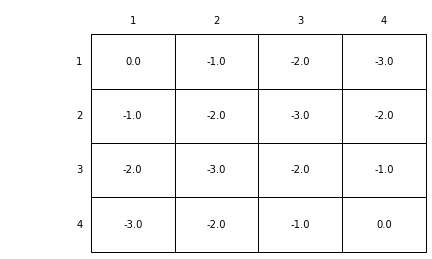

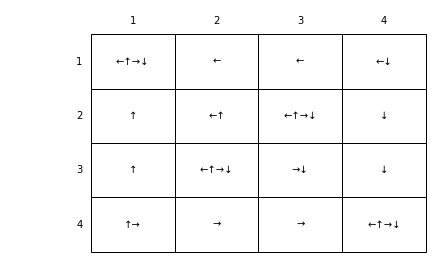

In [6]:
policyPI, valuePI = policy_iteration(env, discount_factor=1.0)
env.draw_image(np.round(valuePI.reshape(4,4), decimals=2))
plt.show()
env.draw_policy(valuePI.reshape(4,4))


## An Interesting Observation

* Currently, we initialize the state values to 0 in Policy Evaluation. If we initialize the state values to 1, what will happen? Think about the reason.

* What if we set the discount factor to 0.9? Try it.




## Section 2: Value Iteration
<img src="https://i.loli.net/2021/03/23/eHjkaPwEdKY2Jvq.png" style="width: 800px;" center/>


## A Trick:
In-place operation: An in-place operation is an operation that changes directly the content of a given Tensor without making a copy.
In our course, we assume that iterative algorithms are implemented in in-place manner.

## Caveat:
In NumPy, assignment operation '=' makes a pointer of an variable. Please use 'copy' when you need to create a copy of an variable.

In [7]:
x_1=np.ones(4)
x_2=x_1
x_3=x_1.copy()
print(x_2 is x_1)
print(x_3 is x_1)

True
False


In [8]:
def value_iteration(env, theta=0.00001, discount_factor=1.0, in_place=True):
    """
    This section is for Value Iteration Algorithm.
    
    Arguments:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: Stop evaluation once value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    
    def one_step_lookahead(state, V):
        """
        Function to calculate the value for all actions in a given state.
        
        Arguments:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, nextState, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[nextState])

        return A
    
    V = np.zeros(env.nS)
    
    numIterations = 0
    
    while True:
        numIterations += 1
        delta = 0
        if in_place:
            old_V=V
        else:
            old_V=V.copy()
        
        for s in range(env.nS):
            qValues = one_step_lookahead(s, old_V)
            newValue = np.max(qValues)
            
            delta = max(delta, np.abs(newValue - old_V[s]))
            V[s] = newValue
        
        if delta < theta:
            break
    
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):  #for all states, create deterministic policy
        qValues = one_step_lookahead(s,V)
        
        newAction = np.argmax(qValues)
        policy[s][newAction] = 1
    
    print(numIterations)    
    return policy, V

4


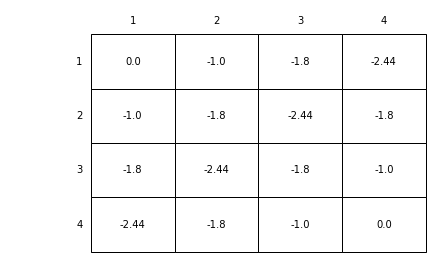

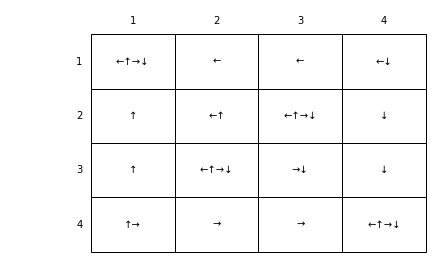

In [9]:
policyVI, valueVI = value_iteration(env, discount_factor=0.8, in_place=0)
env.draw_image(np.round(valueVI.reshape(4,4), decimals=2))
plt.show()
env.draw_policy(valueVI.reshape(4,4))


## Exercise: Taxi-v3

This task was introduced in [Dietterich2000] to illustrate some issues in hierarchical reinforcement learning. There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

Exercise:
* Perform Policy Iteration & Value Iteration on this task
* Compare the numer of iterations for in-place and out-of-place update
* Compare the optimal policies
* Run the optimal policy on thi task

In [10]:
env = gym.make('Taxi-v3')   # Here you set the environment
env._max_episode_steps = 40000
env.reset()

386

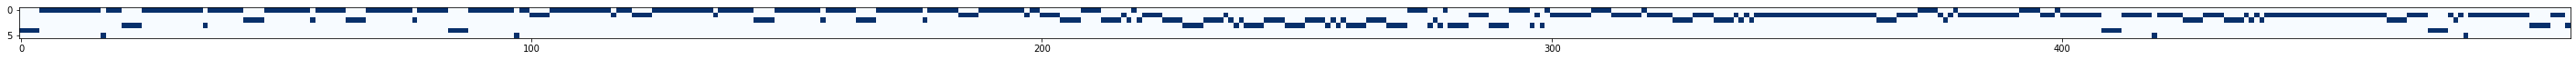

In [11]:
policyPI, valuePI = policy_iteration(env, discount_factor=0.8)
plt.figure(figsize=(50, 6.5))
plt.imshow(policyPI.T, cmap=plt.cm.Blues)
plt.show()

38


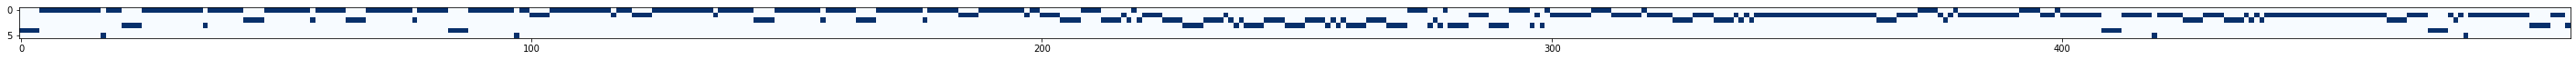

In [12]:
policyVI, valueVI = value_iteration(env, discount_factor=0.8,in_place=1)
plt.figure(figsize=(50, 6.5))
plt.imshow(policyVI.T, cmap=plt.cm.Blues)
plt.show()

67


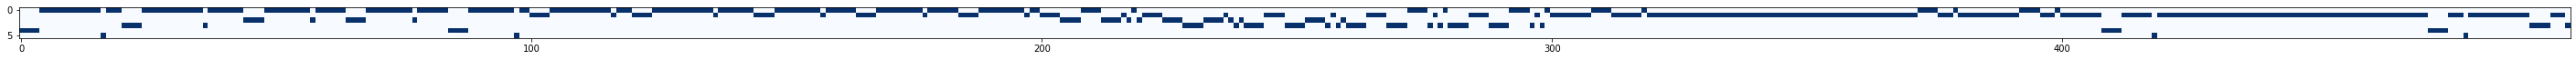

In [13]:
policyVI, valueVI = value_iteration(env, discount_factor=0.8,in_place=0)
plt.figure(figsize=(50, 6.5))
plt.imshow(policyVI.T, cmap=plt.cm.Blues)
plt.show()

Text(0, 0.5, 'Number of Steps')

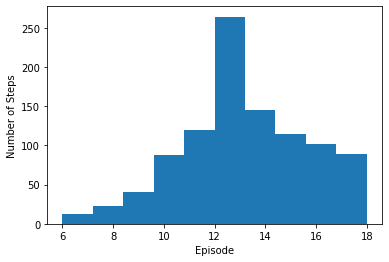

In [14]:
# Use the following function to see the rendering of the final policy output in the environment
def view_policy(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[curr_state])) 
        curr_state = state
        counter += 1
        env.env.s = curr_state
        #env.render()
    
    return counter
polCounter = [view_policy(policyPI) for i in range(1000)]
plt.hist(polCounter) 
plt.xlabel('Episode') 
plt.ylabel('Number of Steps') 